In [1]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [48]:
vehiculo = 'DA04'

In [49]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
elif vehiculo == 'DA04':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_04'
contenido = os.listdir(path_log)
len(contenido)

192

In [50]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [51]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [52]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

25

In [53]:
contenido_filtrado

['2026-02-05 19-40-07.tlog',
 '2026-02-05 21-12-09.tlog',
 '2026-02-05 21-47-01.tlog',
 '2026-02-05 23-18-05.tlog',
 '2026-02-05 23-44-33.tlog',
 '2026-02-06 02-03-41.tlog',
 '2026-02-06 18-48-01.tlog',
 '2026-02-06 19-36-03.tlog',
 '2026-02-06 20-03-19.tlog',
 '2026-02-06 20-33-53.tlog',
 '2026-02-06 21-35-45.tlog',
 '2026-02-06 22-38-03.tlog',
 '2026-02-06 22-59-04.tlog',
 '2026-02-06 23-39-50.tlog',
 '2026-02-06 23-58-19.tlog',
 '2026-02-07 00-33-54.tlog',
 '2026-02-07 00-53-55.tlog',
 '2026-02-07 01-20-39.tlog',
 '2026-02-07 01-52-14.tlog',
 '2026-02-07 02-07-46.tlog',
 '2026-02-07 03-10-26.tlog',
 '2026-02-07 04-14-57.tlog',
 '2026-02-07 05-06-09.tlog',
 '2026-02-07 05-14-10.tlog',
 '2026-02-07 05-54-07.tlog']

In [54]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        print(name)
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [55]:
lineas, names = leer_logs(contenido_filtrado)
lineas

2026-02-05 19-40-07.tlog
2026-02-05 21-12-09.tlog
2026-02-05 21-47-01.tlog
2026-02-05 23-18-05.tlog
2026-02-05 23-44-33.tlog
2026-02-06 02-03-41.tlog
2026-02-06 18-48-01.tlog
2026-02-06 19-36-03.tlog
2026-02-06 20-03-19.tlog
2026-02-06 20-33-53.tlog
2026-02-06 21-35-45.tlog
2026-02-06 22-38-03.tlog
2026-02-06 22-59-04.tlog
2026-02-06 23-39-50.tlog
2026-02-06 23-58-19.tlog
2026-02-07 00-33-54.tlog
2026-02-07 00-53-55.tlog
2026-02-07 01-20-39.tlog
2026-02-07 01-52-14.tlog
2026-02-07 02-07-46.tlog
2026-02-07 03-10-26.tlog
2026-02-07 04-14-57.tlog
2026-02-07 05-06-09.tlog
2026-02-07 05-14-10.tlog
2026-02-07 05-54-07.tlog


[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-62.831 -17.163, -62.831 -17.163, -62.831 -17.163, -62.831 -17....>,
 <LINESTRING (-62.831 -17.163, -62.831 -17.163, -62.831 -17.163, -62.831 -17....>,
 <LINESTRING (-62.826 -17.162, -62.826 -17.162, -62.826 -17.162, -62.826 -17....>,
 <LINESTRING (0 0, 0 0, -62.827 -17.164, -62.827 -17.164, -62.827 -17.164, -6...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -62.829 -17.17, -6...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-63.15 -17.314, -63.15 -17.314, -63.15 -17.314, -63.15 -17.314,...>,
 <LINESTRING (-63.15 -17.314, -63.15 -17.314, -63.15 -17.314, -63.15 -17.314,...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, -63.15 -17.314, -6...>,
 <LINESTRING (-63.152 -17.308, -63.152 -17.308, -63.152 -17.308, -63.152 -17....>,
 <LINESTRING (-63.142 -17.312, -63.142 -17.312, -63.142 -17.312, -63.142 -17....>,
 <LI

In [56]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2026-02-05 19-40-07.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2026-02-05 21-12-09.tlog,"LINESTRING (-62.83148 -17.16274, -62.83148 -17..."
2,2026-02-05 21-47-01.tlog,"LINESTRING (-62.83150 -17.16271, -62.83150 -17..."


In [57]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [58]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [59]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [60]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2026-02-05 19-40-07.tlog,"LINESTRING (-62.83436 -17.17557, -62.83436 -17...",4087,DA04
1,2026-02-05 19-40-07.tlog,"LINESTRING (-62.83437 -17.17556, -62.83437 -17...",2898,DA04
2,2026-02-05 21-12-09.tlog,"LINESTRING (-62.83148 -17.16274, -62.83148 -17...",4336,DA04


<Axes: >

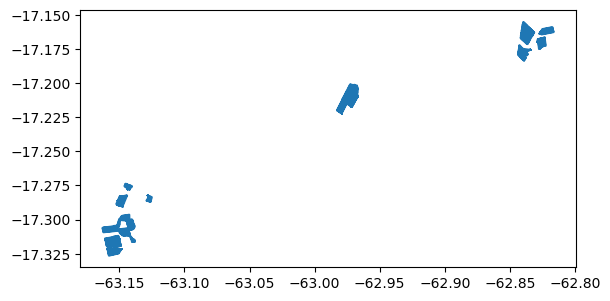

In [61]:
gdf_lines.plot()

In [62]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

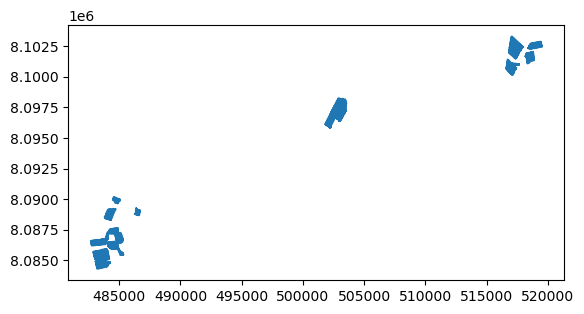

In [63]:
gdf_lines_utm.plot()

In [64]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [65]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2026-02-05 19-40-07.tlog,"LINESTRING (517614.417 8101014.296, 517614.523...",4087,DA04,0
1,2026-02-05 19-40-07.tlog,"LINESTRING (517614.057 8101016.387, 517614.057...",2898,DA04,0
2,2026-02-05 21-12-09.tlog,"LINESTRING (517922.772 8102434.109, 517922.644...",4336,DA04,0
3,2026-02-05 21-12-09.tlog,"LINESTRING (517921.922 8102435.625, 517921.933...",5038,DA04,0
4,2026-02-05 21-47-01.tlog,"LINESTRING (517920.403 8102437.263, 517920.392...",4495,DA04,0
5,2026-02-05 23-18-05.tlog,"LINESTRING (518489.342 8102510.617, 518489.310...",2837,DA04,0
6,2026-02-05 23-44-33.tlog,"LINESTRING (518396.158 8102344.615, 518396.158...",104,DA04,0
7,2026-02-05 23-44-33.tlog,"LINESTRING (518396.594 8102345.256, 518396.594...",10,DA04,0
8,2026-02-05 23-44-33.tlog,"LINESTRING (518394.605 8102344.783, 518394.605...",2298,DA04,0
9,2026-02-06 02-03-41.tlog,"LINESTRING (518213.709 8101677.982, 518213.656...",4302,DA04,0


In [66]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)